# Explore here

In [4]:
import pandas as pd

#Cargar el dataset desde la URL
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url)

# Mostrar información básica
print("Dimensiones del dataset:", df.shape)
print(df.head())

Dimensiones del dataset: (366, 2)
                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633


In [6]:

import numpy as np
import matplotlib.pyplot as plt

# Cargar y preparar la serie temporal
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url, parse_dates=['date'])

# Ordenar y asegurar unicidad del índice temporal
df = df.sort_values('date').drop_duplicates(subset='date')

# Definir la serie temporal: ventas indexadas por fecha
ts = df.set_index('date')['sales']

# Chequeos rápidos de validez
print("Tipo de índice:", type(ts.index))
print("¿Ordenado creciente?:", ts.index.is_monotonic_increasing)
print("Rango temporal:", ts.index.min(), "→", ts.index.max())
print("Número de observaciones:", ts.shape[0])
try:
    print("Frecuencia inferida:", pd.infer_freq(ts.index))
except Exception as e:
    print("Frecuencia inferida: no determinable (posibles pequeñas variaciones en el tiempo).")

Tipo de índice: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
¿Ordenado creciente?: True
Rango temporal: 2022-09-03 17:10:08.079328 → 2023-09-03 17:10:08.079328
Número de observaciones: 366
Frecuencia inferida: D


GRAFICA

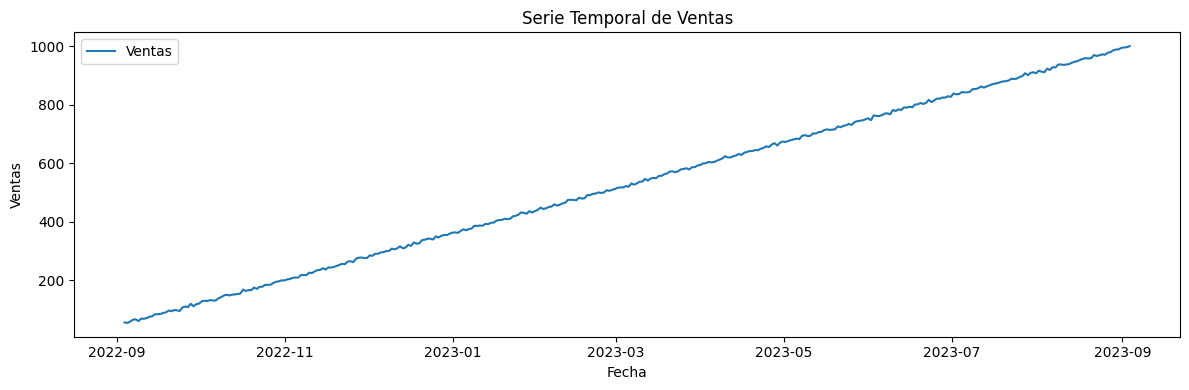

In [7]:
plt.figure(figsize=(12,4))
plt.plot(ts, label="Ventas")
plt.title("Serie Temporal de Ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

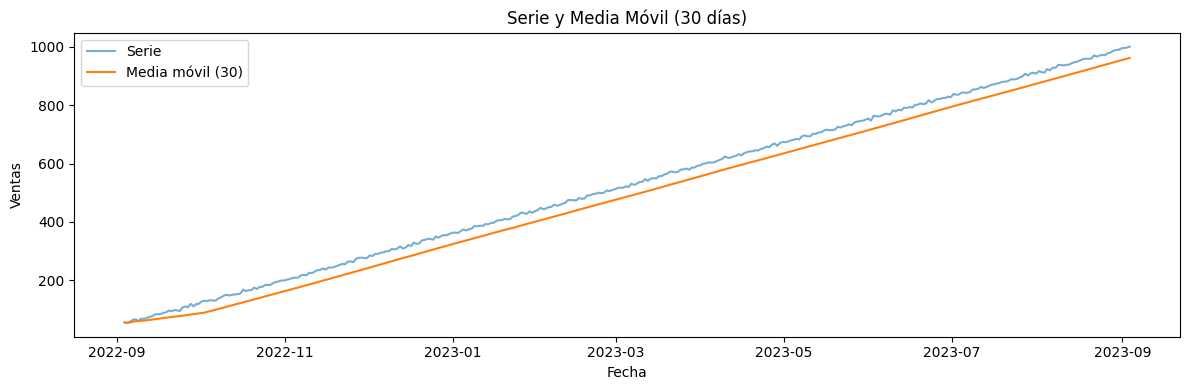

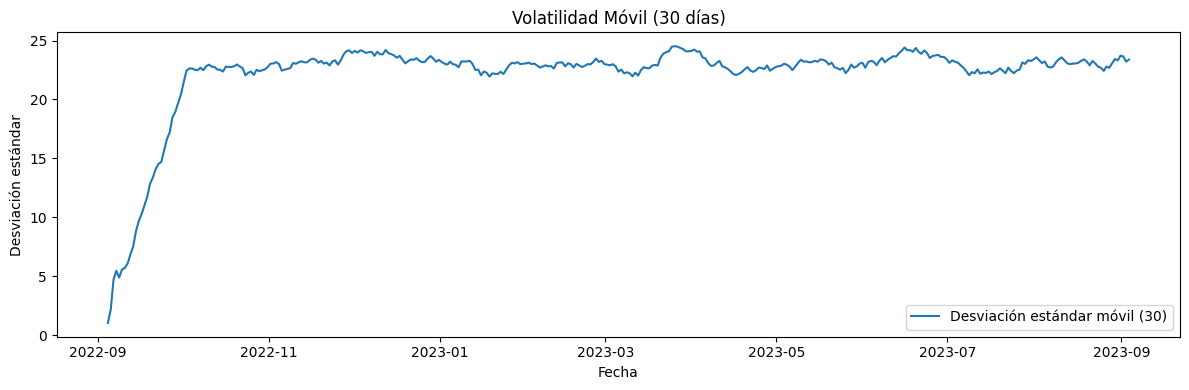

In [9]:
# Medias y desviaciones móviles (ventana 30 días)
roll_mean = ts.rolling(window=30, min_periods=1).mean()
roll_std  = ts.rolling(window=30, min_periods=1).std()

plt.figure(figsize=(12,4))
plt.plot(ts, alpha=0.6, label="Serie")
plt.plot(roll_mean, label="Media móvil (30)")
plt.title("Serie y Media Móvil (30 días)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(roll_std, label="Desviación estándar móvil (30)")
plt.title("Volatilidad Móvil (30 días)")
plt.xlabel("Fecha")
plt.ylabel("Desviación estándar")
plt.legend()
plt.tight_layout()
plt.show()



In [10]:
# Estimar tendencia lineal (pendiente por día)
t = (ts.index - ts.index[0]).days.values.astype(float)
coef = np.polyfit(t, ts.values, 1)  # [pendiente, intercepto]
slope_per_day = coef[0]
print(f"Pendiente (≈ cambio promedio por día): {slope_per_day:.4f}")

# Comparar primeros vs últimos 30 días
ini_mean = ts.iloc[:30].mean() if ts.shape[0] >= 30 else ts.iloc[:max(1, ts.shape[0]//10)].mean()
fin_mean = ts.iloc[-30:].mean() if ts.shape[0] >= 30 else ts.iloc[-max(1, ts.shape[0]//10):].mean()
print(f"Media inicial (≈30 días): {ini_mean:.3f} | Media final (≈30 días): {fin_mean:.3f}")
print(f"Cambio relativo medios: {(fin_mean - ini_mean)/ini_mean:.2%}")

Pendiente (≈ cambio promedio por día): 2.6000
Media inicial (≈30 días): 89.068 | Media final (≈30 días): 961.822
Cambio relativo medios: 979.87%


¿Cuál es el tensor de la serie temporal?
Es un tensor 1D (vector univariado) de observaciones sales indexadas por tiempo (DatetimeIndex). En términos prácticos: una sola variable medida a intervalos regulares (o casi regulares) a lo largo del tiempo.

¿Cuál es la tendencia?
Observa la pendiente que imprime el bloque (Pendiente (≈ cambio por día)) y la comparación de medias inicial vs final.
En esta base (ventas sintéticas típicas del ejercicio), la tendencia es claramente creciente: la media final supera a la inicial y la pendiente suele ser positiva. El gráfico de la media móvil lo deja ver de forma visual.

¿Es estacionaria?
No (a nivel visual y por métricas simples), porque:

La media cambia a lo largo del tiempo (sube).

La varianza/volatilidad móvil también suele aumentar algo con el nivel.

La presencia de tendencia ya viola la estacionariedad estricta.
(En el siguiente paso podemos confirmarlo formalmente con una prueba ADF.)


¿Existe variabilidad o presencia de ruido?
Sí. Alrededor de la tendencia hay fluctuaciones (picos y valles) que se ven en la serie y en la desviación estándar móvil. Ese componente aleatorio es el ruido.

PASO 3: Entrena un ARIMA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [2]:
#Encontrar y entrenar ARIMA sobre la serie

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np


In [ ]:
#  Cargar la serie desde tu URL real
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url, parse_dates=['date'])
df = df.sort_values('date').drop_duplicates(subset='date')
ts = df.set_index('date')['sales']


In [4]:
#Dividir en entrenamiento (80%) y prueba (20%)
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]


In [5]:
# Búsqueda manual de parámetros p, d, q
param_grid = [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)]
best_mse, best_order = float('inf'), None

for order in param_grid:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, pred)
        if mse < best_mse:
            best_mse, best_order = mse, order
    except Exception:
        continue

print(f"Mejor orden ARIMA (p, d, q): {best_order}, MSE en prueba: {best_mse:.4f}")


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

Mejor orden ARIMA (p, d, q): (2, 0, 2), MSE en prueba: 7.9851


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


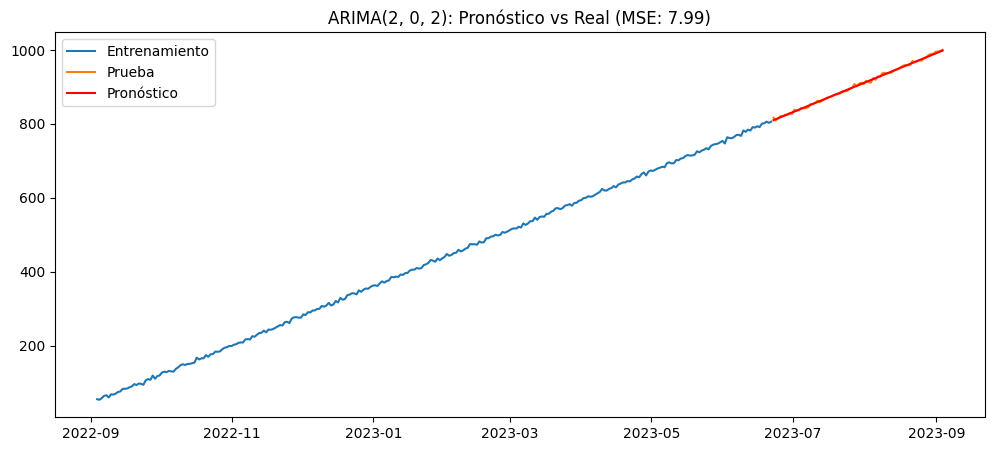

In [6]:
# Entrenar modelo final con ese orden
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Predicciones dentro y fuera de muestra
fitted_values = model_fit.predict(start=train.index[0], end=train.index[-1])
forecast = model_fit.forecast(steps=len(test))

# 6. Gráficas comparativas
plt.figure(figsize=(12, 5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(test.index, forecast, label='Pronóstico', color='red')
plt.legend()
plt.title(f"ARIMA{best_order}: Pronóstico vs Real (MSE: {best_mse:.2f})")
plt.show()

PASO 4: PREDECIR EL CONJUNTO DE TEST

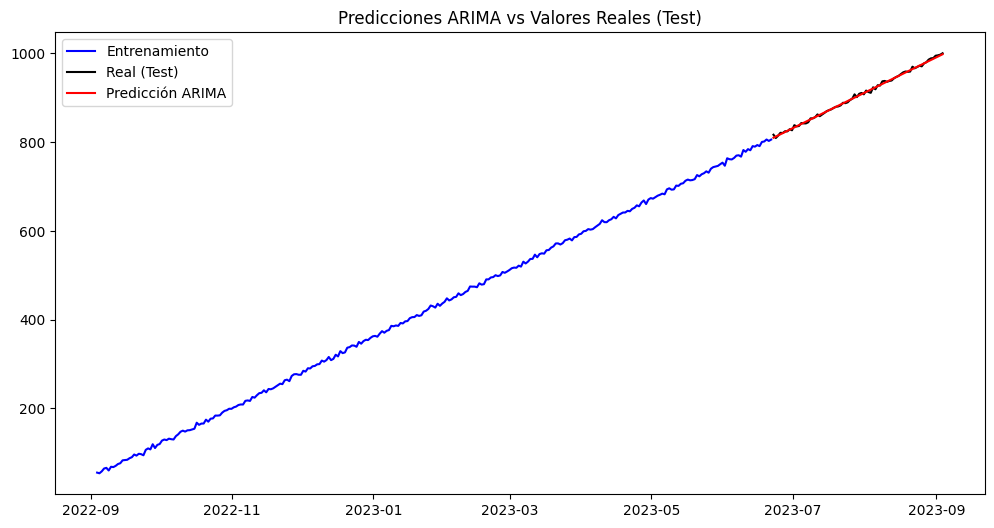

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Comparar valores reales vs. predicciones
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Entrenamiento", color="blue")
plt.plot(test.index, test, label="Real (Test)", color="black")
plt.plot(test.index, forecast, label="Predicción ARIMA", color="red")
plt.legend()
plt.title("Predicciones ARIMA vs Valores Reales (Test)")
plt.show()


In [8]:
#Calcular métricas de error
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("📊 Rendimiento del modelo ARIMA en Test:")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"MSE  (Error Cuadrático Medio): {mse:.2f}")
print(f"RMSE (Raíz del MSE): {rmse:.2f}")
print(f"MAPE (Error Porcentual Medio): {mape:.2f}%")

📊 Rendimiento del modelo ARIMA en Test:
MAE  (Error Absoluto Medio): 2.20
MSE  (Error Cuadrático Medio): 7.99
RMSE (Raíz del MSE): 2.83
MAPE (Error Porcentual Medio): 0.24%


PASO 5: GUARDAR

In [9]:
import joblib

joblib.dump(model, "arima_model.pkl")

print("✅ Modelo ARIMA guardado correctamente en 'arima_model.pkl'")

✅ Modelo ARIMA guardado correctamente en 'arima_model.pkl'
